# Assignement

Customer manages a fleet of machines transmitting daily aggregated telemetry data. He engaged with the EMEA prototype team to better understand machine event rates to improve his machine maintenance and provisioning.

The customer provides you with a sample dataset with machine events statistics. 
The dataset is partitioned by day and contains the machine serial number, a boolean that indicates if the machine had event (1=event) that specific day or not (=0) and (9) features that characterize the machine.


You are tasked with building a model using machine learning to predict the probability of a machine event. When building this model, be sure to minimize false positives and false negatives. The column you are trying to predict is called event with binary value 0 for non-event and 1 for event. 

## 1. Overview

Using the given dataset, we are going to build and tune the model (or more models) that will try to predict which machine will get so called  "1-event". 
I will follow the classical ML way:
- analyze the given dataset to understand its complexity and if possible reduce its complexity 
- analyze event distribution and its correlation to features in order to chose best feature set for the given task 
- analyze features distribution and their correlation in order to simplify or reduce the number of features
- do necessairy Feature Engineering based on analyzes
- prepare training and dataset
- choose one or more model
- define training parameters and performance measures. My goal would be to minimize false positives and false negatives 
- train/tune model(s)
- evaluate model(s)
- draw  conclusion based on results and propose further steps to improve results

## 2. Import Libraries and Load Data


I will import python libraries which I will need for this task. 

In [2]:
pip install pandas_profiling

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### 2.1 Libraries

In [3]:
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import warnings
warnings.filterwarnings("ignore")

The only file containing dataset is machine_event.csv. I will read it as panda's Data Frame and plot first 5 rows

### 2.2 Data 

In [4]:
df = pd.read_csv('machine_event.csv')

In [5]:
df.head()

,date,machine,event,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9
0,2015-01-01,S1F01085,0,0,7,407438,215630672,6,0,52,56,0.0
1,2015-01-01,S1F0166B,0,3,0,403174,61370680,6,0,0,0,0.0
2,2015-01-01,S1F01E6Y,0,0,0,237394,173295968,12,0,0,0,0.0
3,2015-01-01,S1F01JE0,0,0,0,410186,79694024,6,0,0,0,0.0
4,2015-01-01,S1F01R2B,0,0,3,313173,135970480,15,0,0,0,0.0


There are 12 columns. First column (data) is our date stamp followed by machine, which is defining the SN of the machine. Third is event - our outcome defined as 0 - for no event and 1 - for event occured. Last 9 columns represent telemetry data of 9 sensors deliver daily. One row of data per one observed machine daily

## 3. Data Analysis


### 3.1 Detailed Data Analysis

Do we have missing data in the dataset? Co called "nands" need to be localized and "neutralize" to prevent errors

In [6]:
# Are there missing values in  dataset?
df.isnull().sum()

date        0
machine     0
event       0
feature1    0
feature2    0
feature3    0
feature4    0
feature5    0
feature6    0
feature7    0
feature8    0
feature9    0
dtype: int64

There are no missing values in the dataset! Now let us check how many unique machines do we observe and how many 1-events vs 0-events are there in the dataset

In [7]:
# How many unique machines are there in the dataset?
len(df['machine'].unique())

1168

In [8]:
# How many 0-events are there in the dataset. We may think about them as machine is "working normally" - no failures"
# How many 1-events are here in the dataset. This event we may describe as machine failure
df['event'].value_counts()

0    124388
1       106
Name: event, dtype: int64

There are less than 0.1% of 1-events. Dataset is extreemly imbalanced. We will have to perform some data augmentation. First we will do "smart" downscalling of 0-events based on the observation, that most of the 1-events happen in the last day of machine reporting. I will leave in the dataset only last day observation of each machine. This will still give us about 1100 0-events in the dataset, but more importantly also all 106 of our 1-events. Having arround 10% representation of 1-event in the dataset will improve balance and will help our model(s) to learn effectivelly. Having several thousands of same 0-event records in the original dataset would be unnecessairy or even contraproductive. By this "smart" downsampling we will get arround 10% representation of 1-event in the new dataset and we will improve the class balance. In the second step we will split the dataset into train and test dataset and upscale the (still in minority) 1-event class using RandomOverSampler function from imblearn. RandomOverSampler will augment the number of 1-events in the training set to the same number as 0-events. This would give us "perfectly" balanced dataset for training. Before doing that however let us check our features in the original, large dataset. I will check their histogram and correlation for further improvements.

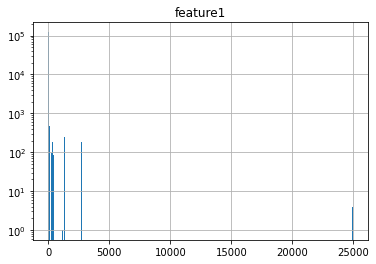

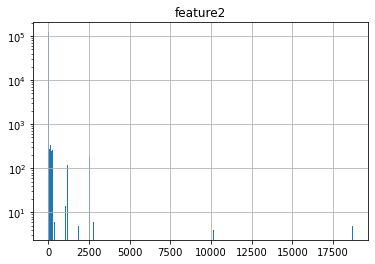

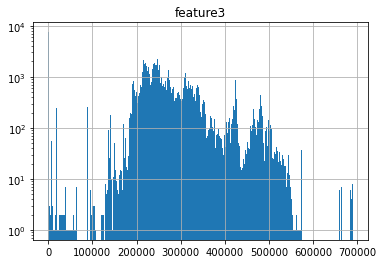

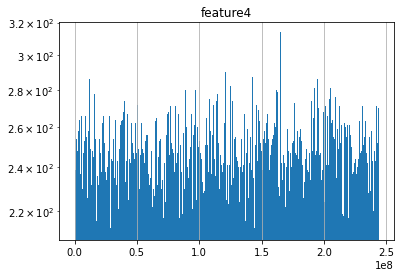

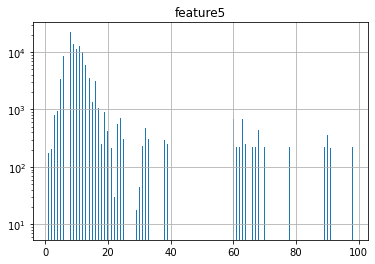

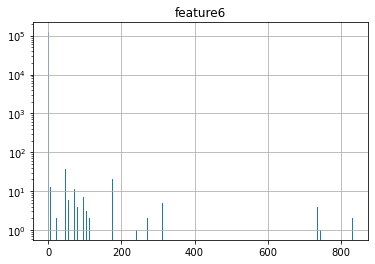

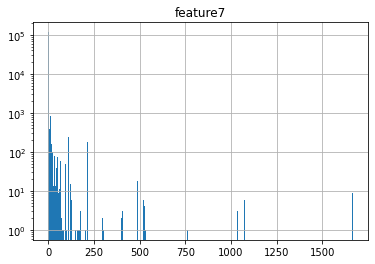

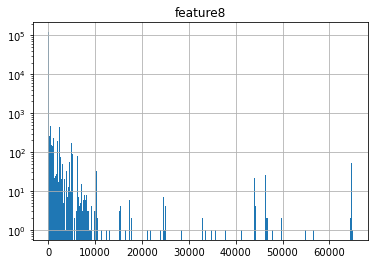

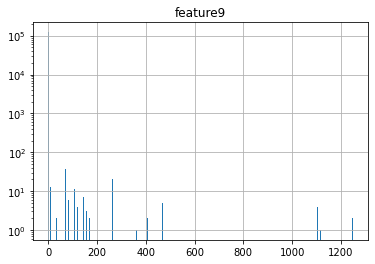

In [9]:
#Plotting the histograms of Features
for name in ['feature1','feature2','feature3','feature4','feature5','feature6','feature7','feature8','feature9']:
    df.hist(column=[name], log=True, bins=500)

We can see that will need to scale our features

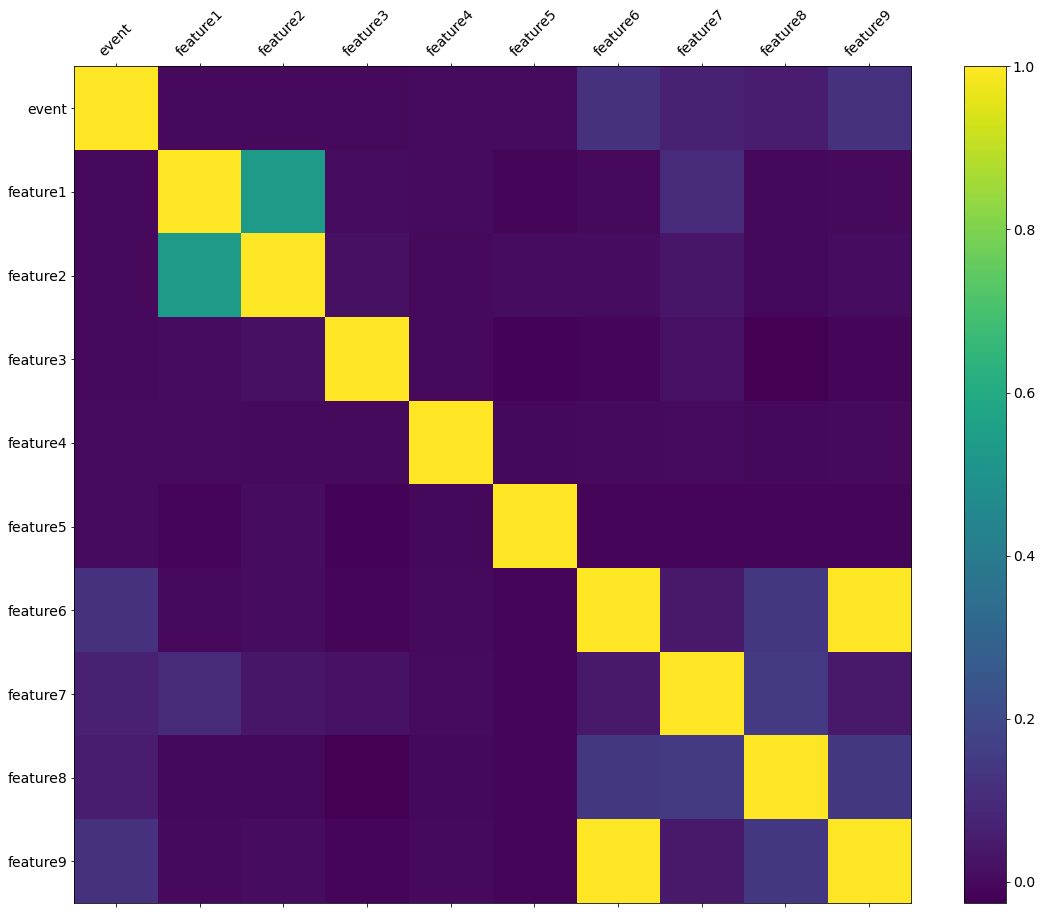

In [10]:
#Plotting the correlation matrix of features and event
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)


Feature 6 and Feature 9 are 100% correlated. We can later delete Feature 9. Only Features 6-9 are correlated with the event. Others - not. We may delete them as well.

### 3.2 Dataset Summary

In [11]:
#df.profile_report(style={'full_width':True})

- The dataset is clean, and there are no missing values.
- The dataset is imbalanced, only about 0.1% of the events are 1s. We will need to do "smart" downsampling of 0-events and upsampling 1-events. 
- Feature6 and Feature9 are 100% correlated. We can later delete Feature9
- Feature 6, 7, 8, 9 are correlated with event, others not. We may try to leave in the dataset only feature 6 7 and 8 (9 will be deleted) and train the model performance
- The magnitudes differ by a wide margin. Therefore scaling needs to be done. I will use minmaxscaler to normalize the feature for the range 0 to 1.


In order to get some statistics on machine behaviour we will group records by mounth and aggregate by machines. 

### 3.3 Machine 1-event Versus Time

In [12]:
# Converting string into datetime format 
df.date = pd.to_datetime(df.date)

In [13]:
# Returns the month of the date
df['month']=df['date'].dt.month

In [14]:
# Showing how many machines reported features each month
df.groupby('month').agg({'machine':lambda x: x.nunique()})

,machine
month,
1,1164
2,726
3,685
4,491
5,424
6,352
7,346
8,334
9,184


We see that the amonut of machines that are checked monthly is deacreasing, from 1164 in January to 31 in November. We do not have information about reasons of this decrease.

<AxesSubplot:xlabel='month'>

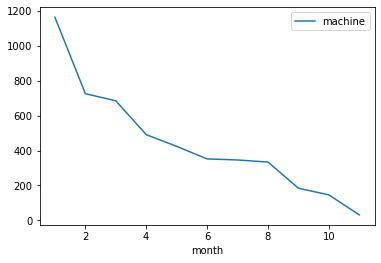

In [15]:
df.groupby('month').agg({'machine':lambda x: x.nunique()}).plot()

In [16]:
# Looking at how many machines are checked daily
df['day']=df.date-df.date[0]

In [17]:
df

,date,machine,event,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,month,day
0,2015-01-01,S1F01085,0,0,7,407438,215630672,6,0,52,56,0.0,1,0 days
1,2015-01-01,S1F0166B,0,3,0,403174,61370680,6,0,0,0,0.0,1,0 days
2,2015-01-01,S1F01E6Y,0,0,0,237394,173295968,12,0,0,0,0.0,1,0 days
3,2015-01-01,S1F01JE0,0,0,0,410186,79694024,6,0,0,0,0.0,1,0 days
4,2015-01-01,S1F01R2B,0,0,3,313173,135970480,15,0,0,0,0.0,1,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,0,0,353705,18310224,10,8,0,0,12.0,11,305 days
124490,2015-11-02,Z1F0Q8RT,0,107,13,332792,172556680,11,0,4,96,0.0,11,305 days
124491,2015-11-02,Z1F0QK05,0,0,0,350410,19029120,11,0,0,4832,0.0,11,305 days
124492,2015-11-02,Z1F0QL3N,0,0,0,358980,226953408,12,0,0,0,0.0,11,305 days


Showing the number of machines that are checked day by day. The trend is decreasing and the number of machines taken out of observation my drop from day to day by 30% of their population

<AxesSubplot:xlabel='day'>

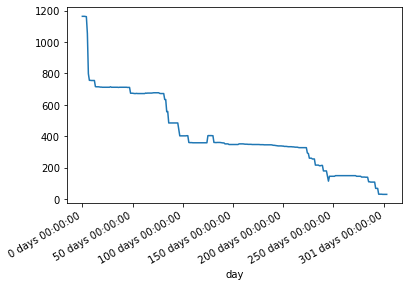

In [18]:
df.groupby('day')['machine'].count().plot()

## 4. Feature Engineering

### 4.1 Group By Machine

Now we will regroup all records by machine, find its last reporting day (max_day) and add it to our new dataset (df2). This data frame will consit of only one, last record per machine

In [19]:
# Finding all records with the 1-event and writing them to df_failure
df_failure = df.loc[df.event==1,['machine','date']]
df_failure


,machine,date
4885,S1F0RRB1,2015-01-05
6879,S1F0CTDN,2015-01-07
8823,W1F0PNA5,2015-01-09
11957,W1F13SRV,2015-01-13
12668,W1F1230J,2015-01-14
...,...,...
109927,W1F1CB5E,2015-08-04
114251,Z1F0MRPJ,2015-08-18
122118,S1F0JGJV,2015-10-05
122808,Z1F14BGY,2015-10-09


These are all 106 records withe 1-event

In [20]:
# Grouping all records of df by 'machine' and find its last day of reporting. Add this column to the the new df_date 
df_date = df.groupby('machine').agg({'date':max})

In [21]:
df_date

,date
machine,
S1F01085,2015-01-06
S1F013BB,2015-05-11
S1F0166B,2015-01-06
S1F01E6Y,2015-02-17
S1F01JE0,2015-01-06
...,...
Z1F1VMZB,2015-10-19
Z1F1VQFY,2015-06-30
Z1F26YZB,2015-03-25


In [22]:
df_date.shape,df_failure.shape

((1168, 1), (106, 2))

In [23]:
# Adding new column 'max_date' to df

In [24]:
# Adding new column 'max_date' to df and mapping there the column 'date' from df.date
df['max_date']=df.machine.map(df_date.date.to_dict())
df.head()

,date,machine,event,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,month,day,max_date
0,2015-01-01,S1F01085,0,0,7,407438,215630672,6,0,52,56,0.0,1,0 days,2015-01-06
1,2015-01-01,S1F0166B,0,3,0,403174,61370680,6,0,0,0,0.0,1,0 days,2015-01-06
2,2015-01-01,S1F01E6Y,0,0,0,237394,173295968,12,0,0,0,0.0,1,0 days,2015-02-17
3,2015-01-01,S1F01JE0,0,0,0,410186,79694024,6,0,0,0,0.0,1,0 days,2015-01-06
4,2015-01-01,S1F01R2B,0,0,3,313173,135970480,15,0,0,0,0.0,1,0 days,2015-08-24


In [25]:
# Merging two data frames to obtain new data frame df2
df =df.reset_index(drop =True)
df2 = pd.merge(df_date,df,how='left', on = ['machine','date'])
df2
df2.shape

(1168, 15)

In [26]:
df2

,machine,date,event,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,month,day,max_date
0,S1F01085,2015-01-06,0,0,7,409404,128832128,6,0,52,56,0.0,1,5 days,2015-01-06
1,S1F013BB,2015-05-11,0,0,0,689161,115676688,5,0,0,0,0.0,5,130 days,2015-05-11
2,S1F0166B,2015-01-06,0,3,0,404786,7441792,6,0,0,0,0.0,1,5 days,2015-01-06
3,S1F01E6Y,2015-02-17,0,0,0,259491,147350000,12,0,0,0,0.0,2,47 days,2015-02-17
4,S1F01JE0,2015-01-06,0,0,0,412151,185424928,6,0,0,0,0.0,1,5 days,2015-01-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,Z1F1VMZB,2015-10-19,0,0,0,263507,96949360,5,0,0,0,0.0,10,291 days,2015-10-19
1164,Z1F1VQFY,2015-06-30,1,0,0,265316,178051496,7,0,0,0,0.0,6,180 days,2015-06-30
1165,Z1F26YZB,2015-03-25,0,1,0,292052,229065488,1,0,0,0,0.0,3,83 days,2015-03-25
1166,Z1F282ZV,2015-03-25,0,1,0,192919,72717600,1,0,0,0,0.0,3,83 days,2015-03-25


### 4.2 Date Feature

In [27]:
# Changing 'day' column to categorical value
cat_columns = ['day']
df2[cat_columns]= df2[cat_columns].astype(str)
df2.head()

,machine,date,event,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,month,day,max_date
0,S1F01085,2015-01-06,0,0,7,409404,128832128,6,0,52,56,0.0,1,5 days,2015-01-06
1,S1F013BB,2015-05-11,0,0,0,689161,115676688,5,0,0,0,0.0,5,130 days,2015-05-11
2,S1F0166B,2015-01-06,0,3,0,404786,7441792,6,0,0,0,0.0,1,5 days,2015-01-06
3,S1F01E6Y,2015-02-17,0,0,0,259491,147350000,12,0,0,0,0.0,2,47 days,2015-02-17
4,S1F01JE0,2015-01-06,0,0,0,412151,185424928,6,0,0,0,0.0,1,5 days,2015-01-06


In [28]:
df2['day']= df2['day'].apply( lambda x: int(x.split(' ')[0]))

In [29]:
# dropping two columns
df2.drop(['date','max_date'],axis=1,inplace=True)

In [30]:
df2

,machine,event,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,month,day
0,S1F01085,0,0,7,409404,128832128,6,0,52,56,0.0,1,5
1,S1F013BB,0,0,0,689161,115676688,5,0,0,0,0.0,5,130
2,S1F0166B,0,3,0,404786,7441792,6,0,0,0,0.0,1,5
3,S1F01E6Y,0,0,0,259491,147350000,12,0,0,0,0.0,2,47
4,S1F01JE0,0,0,0,412151,185424928,6,0,0,0,0.0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,Z1F1VMZB,0,0,0,263507,96949360,5,0,0,0,0.0,10,291
1164,Z1F1VQFY,1,0,0,265316,178051496,7,0,0,0,0.0,6,180
1165,Z1F26YZB,0,1,0,292052,229065488,1,0,0,0,0.0,3,83
1166,Z1F282ZV,0,1,0,192919,72717600,1,0,0,0,0.0,3,83


### 4.3 Machine Class Feature

In [31]:
# Normally the first four characters of the 'machine' serial number represent the brand of the machine producer. We can do some statistics to check if some brands have more 
# 1-events
df2['machine_class'] = df2.machine.apply(lambda x: x[:4])
df2['machine_class']

0       S1F0
1       S1F0
2       S1F0
3       S1F0
4       S1F0
        ... 
1163    Z1F1
1164    Z1F1
1165    Z1F2
1166    Z1F2
1167    Z1F2
Name: machine_class, Length: 1168, dtype: object

In [32]:
dev=pd.crosstab(df2['machine_class'],df2['event'])

In [33]:
dev

event,0,1
machine_class,,
S1F0,356,35
S1F1,134,5
W1F0,257,25
W1F1,123,14
Z1F0,136,13
Z1F1,58,9
Z1F2,3,0


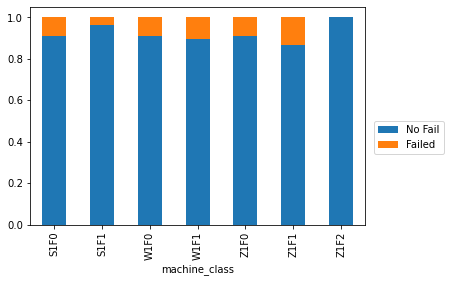

In [34]:
# Print 1-Event vs 0-Event stats per Machine class
dev.div(dev.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True).legend(["No Fail", "Failed"], bbox_to_anchor=(1.25, 0.5))

Only Z1F2 serie of machines does not have 1-Events

In [35]:
df2

,machine,event,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,month,day,machine_class
0,S1F01085,0,0,7,409404,128832128,6,0,52,56,0.0,1,5,S1F0
1,S1F013BB,0,0,0,689161,115676688,5,0,0,0,0.0,5,130,S1F0
2,S1F0166B,0,3,0,404786,7441792,6,0,0,0,0.0,1,5,S1F0
3,S1F01E6Y,0,0,0,259491,147350000,12,0,0,0,0.0,2,47,S1F0
4,S1F01JE0,0,0,0,412151,185424928,6,0,0,0,0.0,1,5,S1F0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,Z1F1VMZB,0,0,0,263507,96949360,5,0,0,0,0.0,10,291,Z1F1
1164,Z1F1VQFY,1,0,0,265316,178051496,7,0,0,0,0.0,6,180,Z1F1
1165,Z1F26YZB,0,1,0,292052,229065488,1,0,0,0,0.0,3,83,Z1F2
1166,Z1F282ZV,0,1,0,192919,72717600,1,0,0,0,0.0,3,83,Z1F2


## 5. Preprocessing Data 

### 5.1 Data Transformation

We will scale all our features using minimax_scale to range (0, 1)

In [36]:
from sklearn import preprocessing
# scaling
# Create scaler
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))

# Scale feature using minimax scaling
df2['feature3'] = minmax_scale.fit_transform(df2['feature3'].values.reshape(-1,1))
df2['feature4'] = minmax_scale.fit_transform(df2['feature4'].values.reshape(-1,1))
df2['feature8'] = minmax_scale.fit_transform(df2['feature8'].values.reshape(-1,1))

df2['feature1'] = minmax_scale.fit_transform(df2['feature1'].values.reshape(-1,1))
df2['feature2'] = minmax_scale.fit_transform(df2['feature2'].values.reshape(-1,1))
df2['feature5'] = minmax_scale.fit_transform(df2['feature5'].values.reshape(-1,1))
df2['feature6'] = minmax_scale.fit_transform(df2['feature6'].values.reshape(-1,1))
df2['feature7'] = minmax_scale.fit_transform(df2['feature7'].values.reshape(-1,1))




In [37]:
df2

,machine,event,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,month,day,machine_class
0,S1F01085,0,0.00000,0.000374,0.594054,0.529456,0.051546,0.0,0.031212,0.000864,0.0,1,5,S1F0
1,S1F013BB,0,0.00000,0.000000,1.000000,0.475391,0.041237,0.0,0.000000,0.000000,0.0,5,130,S1F0
2,S1F0166B,0,0.00012,0.000000,0.587353,0.030583,0.051546,0.0,0.000000,0.000000,0.0,1,5,S1F0
3,S1F01E6Y,0,0.00000,0.000000,0.376521,0.605558,0.113402,0.0,0.000000,0.000000,0.0,2,47,S1F0
4,S1F01JE0,0,0.00000,0.000000,0.598040,0.762033,0.051546,0.0,0.000000,0.000000,0.0,1,5,S1F0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,Z1F1VMZB,0,0.00000,0.000000,0.382348,0.398428,0.041237,0.0,0.000000,0.000000,0.0,10,291,Z1F1
1164,Z1F1VQFY,1,0.00000,0.000000,0.384973,0.731730,0.061856,0.0,0.000000,0.000000,0.0,6,180,Z1F1
1165,Z1F26YZB,0,0.00004,0.000000,0.423769,0.941380,0.000000,0.0,0.000000,0.000000,0.0,3,83,Z1F2
1166,Z1F282ZV,0,0.00004,0.000000,0.279921,0.298844,0.000000,0.0,0.000000,0.000000,0.0,3,83,Z1F2


### 5.2 Drop some feature columns

In [38]:
# Dropping feature9 column because it is 100% correlated with feature6. feature9=feature6 * 1.5
df2 =df2.drop(columns = ['feature9'])

In [39]:
# Dropping features 1, 2, 3, 4, 5 because they are not correclated with event - Experimental version
df2 =df2.drop(columns = ['feature1','feature2','feature3','feature4','feature5'])

In [40]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 0 to 1167
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   machine        1168 non-null   object 
 1   event          1168 non-null   int64  
 2   feature6       1168 non-null   float64
 3   feature7       1168 non-null   float64
 4   feature8       1168 non-null   float64
 5   month          1168 non-null   int64  
 6   day            1168 non-null   int64  
 7   machine_class  1168 non-null   object 
dtypes: float64(3), int64(3), object(2)
memory usage: 82.1+ KB


### 5.3 Converting Categorical Features

We will do a dummy encoding for categorical values

In [41]:
df2 = pd.get_dummies(df2, drop_first = True)
df2

,event,feature6,feature7,feature8,month,day,machine_S1F013BB,machine_S1F0166B,machine_S1F01E6Y,machine_S1F01JE0,...,machine_Z1F1VQFY,machine_Z1F26YZB,machine_Z1F282ZV,machine_Z1F2PBHX,machine_class_S1F1,machine_class_W1F0,machine_class_W1F1,machine_class_Z1F0,machine_class_Z1F1,machine_class_Z1F2
0,0,0.0,0.031212,0.000864,1,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.0,0.000000,0.000000,5,130,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.0,0.000000,0.000000,1,5,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.0,0.000000,0.000000,2,47,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.0,0.000000,0.000000,1,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,0,0.0,0.000000,0.000000,10,291,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1164,1,0.0,0.000000,0.000000,6,180,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1165,0,0.0,0.000000,0.000000,3,83,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1166,0,0.0,0.000000,0.000000,3,83,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


### 5.4 Defining Train Test

In [42]:
y= df2['event']
result =df2.drop(columns = ['event'])

In [43]:
#import module to split dataset into train and test
from sklearn.model_selection import train_test_split

In [44]:
# 25% for testing
X_train, X_test, y_train, y_test = train_test_split(result, y, test_size=0.25, random_state=42)

In [45]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((876, 1178), (292, 1178), (876,), (292,))

In [46]:
X_train

,feature6,feature7,feature8,month,day,machine_S1F013BB,machine_S1F0166B,machine_S1F01E6Y,machine_S1F01JE0,machine_S1F01R2B,...,machine_Z1F1VQFY,machine_Z1F26YZB,machine_Z1F282ZV,machine_Z1F2PBHX,machine_class_S1F1,machine_class_W1F0,machine_class_W1F1,machine_class_Z1F0,machine_class_Z1F1,machine_class_Z1F2
1045,0.000000,0.000000,0.0,8,223,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
812,0.000000,0.000000,0.0,10,291,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
956,0.000000,0.000000,0.0,5,141,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
628,0.000000,0.009604,0.0,6,161,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
973,0.000000,0.000000,0.0,5,132,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,0.009615,0.000000,0.0,11,305,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1095,0.000000,0.000000,0.0,3,83,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1130,0.000000,0.000000,0.0,1,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
860,0.000000,0.000000,0.0,8,231,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## 6. Building model

### 6.1 Libraries

In [47]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [48]:
pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [49]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import learning_curve, GridSearchCV, KFold, StratifiedKFold, StratifiedShuffleSplit
from imblearn.metrics import geometric_mean_score as geo
from imblearn.metrics import make_index_balanced_accuracy as iba
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy, classification_report_imbalanced

# from imblearn import under_sampling 
# from imblearn import over_sampling
from imblearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)




#parameters for tDMassess function
g = GaussianNB()
b = BernoulliNB()
k = KNeighborsClassifier()
log = LogisticRegression()
gbc = GradientBoostingClassifier()
r = RandomForestClassifier()
xgb = XGBClassifier(random_state=0)
svc = SVC()
algorithms = [g, b, k, log, gbc, r, xgb, svc]
names = ['GaussianNB', 'BernoulliNB', 'K Nearest', 'Logistic', 'Gradient Boosting', 'Random Forest', 'XG Boost', 'SVC']

### 6.2 Oversample within Cross-Validation

In our dataset, the majority of the results do not fail. As mentioned above, only about 0.1% of the classes are failures. Because we have a scarcity of data, we will choose to oversample on the failure to provide more data for modeling. We have to be careful to split the dataset first and then oversample because we do not want to duplicate observations from the train set into the test set to avoid overfitting or memorization of data points.

In [50]:
def kfoldAssessROS(X_train, y_train, algorithms, names ):
    X_train = X_train.values
    y_train = y_train.values
    Accuracy = []
    Precision= []
    Recall= []
    F1 = []

    #fit the data
    for i in range(len(algorithms)):
        j=1
        print('i=',1)
        print(algorithms[i])
        kf = StratifiedKFold(n_splits=5, random_state=69,shuffle=True)
        accuracy = []
        precision= []
        recall= []
        f1 = []
        

        
        for train_index,test_index in kf.split(X_train,y_train):
            print('\n{} of kfold {}'.format(j,kf.n_splits))
            xtrain, xtest = X_train[train_index], X_train[test_index]
            ytrain, ytest = y_train[train_index], y_train[test_index]
            
            xtrain_resample,ytrain_resample=ros.fit_resample(xtrain, ytrain)
            
            fit= algorithms[i].fit(xtrain_resample,ytrain_resample)
            y_pred_test = fit.predict(xtest)
            y_delta = ytest-y_pred_test
            accuracy.append(accuracy_score(ytest,y_pred_test))
            precision.append(precision_score(ytest,y_pred_test))
            recall.append(recall_score(ytest,y_pred_test))
            f1.append(f1_score(ytest,y_pred_test))
            j+=1
        mean_accuracy = np.mean(accuracy)
        mean_precision = np.mean(precision)
        mean_recall = np.mean(recall)
        mean_f1 = np.mean(f1)
        Accuracy.append(mean_accuracy)
        Precision.append(mean_precision)
        Recall.append(mean_recall)
        F1.append(mean_f1)
        print(Accuracy, Precision, Recall, F1)
    metrics = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'F1'], index = names)
    metrics['Accuracy'] =Accuracy
    metrics['Precision'] = Precision
    metrics['Recall']=Recall
    metrics['F1']=F1
    return metrics.sort_values('F1',ascending = False)

In [51]:
kfoldAssessROS(X_train, y_train, algorithms, names )

i= 1
GaussianNB()

1 of kfold 5

2 of kfold 5

3 of kfold 5

4 of kfold 5

5 of kfold 5
[0.09132467532467532] [0.08819280938316218] [1.0] [0.16208105946794876]
i= 1
BernoulliNB()

1 of kfold 5

2 of kfold 5

3 of kfold 5

4 of kfold 5

5 of kfold 5
[0.09132467532467532, 0.8162662337662339] [0.08819280938316218, 0.2966348881763459] [1.0, 0.7658333333333334] [0.16208105946794876, 0.426508007939059]
i= 1
KNeighborsClassifier()

1 of kfold 5

2 of kfold 5

3 of kfold 5

4 of kfold 5

5 of kfold 5
[0.09132467532467532, 0.8162662337662339, 0.9703116883116885] [0.08819280938316218, 0.2966348881763459, 0.881547619047619] [1.0, 0.7658333333333334, 0.765] [0.16208105946794876, 0.426508007939059, 0.8145949820788531]
i= 1
LogisticRegression()

1 of kfold 5

2 of kfold 5

3 of kfold 5

4 of kfold 5

5 of kfold 5
[0.09132467532467532, 0.8162662337662339, 0.9703116883116885, 0.8938246753246754] [0.08819280938316218, 0.2966348881763459, 0.881547619047619, 0.45757575757575764] [1.0, 0.7658333333333334,

,Accuracy,Precision,Recall,F1
K Nearest,0.970312,0.881548,0.765000,0.814595
XG Boost,0.956630,0.822220,0.646667,0.713840
Gradient Boosting,0.937253,0.653974,0.673333,0.653557
Random Forest,0.945227,0.814444,0.517500,0.623940
BernoulliNB,0.816266,0.296635,0.765833,0.426508
SVC,0.584552,0.147356,0.754167,0.246213
Logistic,0.893825,0.457576,0.179167,0.226964
GaussianNB,0.091325,0.088193,1.000000,0.162081


- precision is masurement of relevant results
- recall is a measure of how many truly relevant results are returned
- specificity
- f1 is the harmonic mean of precision and recall

### 6.3 ROC Curve

We will calculate the Receiver Operating Characteristic (ROC) to compare several models.

In [52]:
X_test=X_test.values
y_test=y_test.values

probs1 = xgb.predict_proba(X_test)
probs2 = k.predict_proba(X_test)
probs3 = gbc.predict_proba(X_test)
probs4 = r.predict_proba(X_test)
probs1 = probs1[:,1]
probs2 = probs2[:,1]
probs3 = probs3[:,1]
probs4 = probs4[:,1]

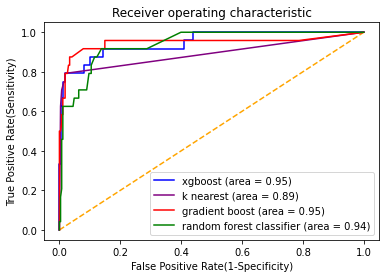

In [53]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, probs1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, probs2)
fpr3, tpr3, thresholds3 = roc_curve(y_test, probs3)
fpr4, tpr4, thresholds4 = roc_curve(y_test, probs4)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.plot(fpr1, tpr1, color = 'blue', label='xgboost (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color = 'purple', label='k nearest (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color = 'red', label='gradient boost (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color = 'green', label='random forest classifier (area = %0.2f)' % roc_auc4)
plt.xlabel('False Positive Rate(1-Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

  The XGBoost Model with an AUROC of 0.95 provided the best result. 

### 6.4 Grid Search

To improve our model's score, we will perform a grid search to find the best combination of parameters. Cross validation is used to allow more data to be used for model to learn and decide on the parameters. We will grid_serch for xgb and knn

In [57]:
## Parameters settings for Grid Search
## Pease choose your algorithm from list: [g, b, k, log, gbc, r, xgb, svc]. 
## I defined parameters only for two algoritms: knn (k) and xgb XGBClassifier
algor = xgb #change here to k for knn, other algorithm may follow

# General parameter for cros validation
cv = KFold(n_splits= 5 )
param = {}

# Parameter set for GridSearchCV for xgb algorithm
estimators = [25, 50, 100, 150, 200]
learning_rate = [0.01,0.05,0.1,0.15,0.2, 0.25]
param[xgb] = {'model__n_estimators': estimators, 'model__learning_rate': learning_rate}

# Parameter set for GridSearchCV for knn
leaf_size = [1, 2, 3, 5, 10, 20, 30, 40, 50]
n_neighbors = [3, 5, 7, 9, 11, 13, 15, 17]
param[k] = {'model__leaf_size': leaf_size, 'model__n_neighbors': n_neighbors}


## Creating pipeline
pipe = Pipeline([('resample', ros), ('model', algor)])

# Performing grid search based on roc_auc scoring
grid = GridSearchCV(pipe, param_grid=param[algor], cv=cv, scoring='roc_auc')
grid.fit(X_train.values, y_train.values)

# Showing achieved score ('roc_auc)'
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.9591017132368481
{'model__learning_rate': 0.1, 'model__n_estimators': 50}
Pipeline(steps=[('resample', RandomOverSampler(random_state=0)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=50, n_jobs=0, num_parallel_tree=1,
        

In [58]:
# Runing prediction on testing set with grid-optimized parameters
grid_pred = grid.predict(X_test)
grid_proba = grid.predict_proba(X_test)
grid_pred = pd.Series(grid_pred)

In [59]:
# Defining performance indexes
def score_result(y, pred):
    print ('Accuracy Score is', accuracy_score(y,pred))
    print ('Precision Score is', precision_score(y, pred))
    print ('Recall Score is', recall_score(y, pred))
    print ('f1_score is ', f1_score(y, pred))

In [60]:
# Running score_result and showing performance
score_result(y_test, grid_pred)

Accuracy Score is 0.9691780821917808
Precision Score is 0.8260869565217391
Recall Score is 0.7916666666666666
f1_score is  0.8085106382978724


## 7. Showing test results

In [61]:
## Printing the predicted event probability
grid_proba1 = pd.DataFrame(grid_proba,columns = ['Prob_0', 'Prob_1'])
grid_proba1

,Prob_0,Prob_1
0,0.992917,0.007083
1,0.993414,0.006586
2,0.929746,0.070254
3,0.849641,0.150359
4,0.986448,0.013552
...,...,...
287,0.980997,0.019003
288,0.992502,0.007498
289,0.984484,0.015516
290,0.992917,0.007083


In [62]:
## Printing prediction
grid_pred1 = pd.DataFrame(grid_pred,columns = ['predict'])
grid_pred1

,predict
0,0
1,0
2,0
3,0
4,0
...,...
287,0
288,0
289,0
290,0


In [63]:
## Printing final results inclusive Actual, predicted values with event's and
## probabilities
y1 = pd.DataFrame(y_test)
y1.columns = ['Actual']

final = pd.concat([y1,grid_pred1], axis =1)
final = pd.concat([final,grid_proba1], axis =1)

In [64]:
final

,Actual,predict,Prob_0,Prob_1
0,0,0,0.992917,0.007083
1,0,0,0.993414,0.006586
2,0,0,0.929746,0.070254
3,0,0,0.849641,0.150359
4,0,0,0.986448,0.013552
...,...,...,...,...
287,0,0,0.980997,0.019003
288,0,0,0.992502,0.007498
289,0,0,0.984484,0.015516
290,0,0,0.992917,0.007083


In [65]:
## Saving final results to final.csv file
final.to_csv('final.csv', index=False)

In [66]:
## Printing final results where Actual event value is 1.
final[final['Actual'] ==1]

,Actual,predict,Prob_0,Prob_1
28,1,0,0.929410,0.070590
40,1,1,0.112255,0.887745
50,1,1,0.033812,0.966188
73,1,1,0.010790,0.989210
75,1,1,0.257223,0.742777
102,1,1,0.450592,0.549408
106,1,1,0.065629,0.934371
108,1,1,0.224875,0.775125
157,1,1,0.077197,0.922803
167,1,0,0.977728,0.022272


FN=5, FP=4
Recall = TP/(TP+FN) = 19/24 = 79%
Precision = TP/(TP+FP) = 19/23 = 83%

## 8. Conclusion

We were able to predict with very hgh accuracy.
Precision, the recall score are lower. We should be able to improve this results bu improving dataset quality and better tuning models. Further imporvement can be done by implementing time serries analysis. 

Achieved XGB Results: Accuracy = 97%, FN=5, FP=4, Recall = 79%, Precision = 83%

Achieved KNN Results: Accuracy = 97.6%, FN=5, FP=2, Recall = 79%, Precision = 90%

We compared performance of following classical models using cross validation:
GaussianNB
BernoulliNB
KNeighborsClassifier
LogisticRegression
GradientBoostingClassifier
RandomForestClassifier
XGBClassifier
SVC
We also tuned two "best" models to find optimal model parameters and then tested them with an invisible test set. The accuracy achieved was very high. Precision, Recall and F1 Score were slower. We should be able to improve these results by improving the quality of the data sets and better tuning models. We should also consider implementing a time-series analysis of features, which should help diagnose the state of the machine just before the 1 event occurs

## 9. Sources

During working on this assignement I studied several code snippets and borrowed ideas from following sources:
1. https://github.com/awslabs/predictive-maintenance-using-machine-learning
2. https://www.kaggle.com/code/debjit00/predictivemaintenanceproject
3. https://github.com/seanjaw/device_maintenance
4. https://github.com/awslabs/predictive-maintenance-using-machine-learning
5. https://colab.research.google.com/github/HarshGupta-DS/Predictive-Maintainence-using-Data-Analysis-and-Time-Series-Forecasting/blob/main/Predictive_Maintenance.ipynb
6. Wearable Systems 1 ETH Zurich prof. Gerhard Troester 2015. Course documentation


           
 